In [36]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import itertools
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
import logging

import nltk.data
nltk.download()

%pylab inline

path = '/Users/troy/code/machine-learning/imdb-example/data/'

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml
Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv(path + 'labeledTrainData.tsv', delimiter='\t')

In [3]:
split = 0.7
d_train = data[:int(split * len(data))]
d_test = data[int(split * len(data)):]

In [4]:
count_vectorizer = CountVectorizer()

count_features = count_vectorizer.fit_transform(d_train.review)
count_test_features = count_vectorizer.transform(d_test.review)

In [5]:
# Not sure exactly what these are yet
i = 45000
j = 10

words = count_vectorizer.get_feature_names()[i:i+10]
pd.DataFrame(count_features[j:j+7, i:i+10].todense(), columns=words)

,producer,producer9and,producers,produces,producing,product,production,productions,productive,productively
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,1,0,0,0
4,0,0,0,0,0,0,1,0,0,0
5,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0


In [6]:
model1 = MultinomialNB()
model1.fit(count_features, d_train.sentiment)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [7]:
pred1 = model1.predict_proba(count_test_features)

In [8]:
def performance(y_true, pred, color='g', ann=True):
    acc = accuracy_score(y_true, pred[:,1] > 0.5) # what is 0.5 here?
    auc = roc_auc_score(y_true, pred[:,1])
    fpr, tpr, thr = roc_curve(y_true, pred[:,1])
    
    plot(fpr, tpr, color, linewidth='3')
    xlabel('False positive rate')
    ylabel('True positive rate')
    
    if ann:
        annotate("Acc: %0.2f" % acc, (0.2, 0.7), size=14)
        annotate("AUC: %0.2f" % auc, (0.2, 0.6), size=14)
        
    fpr_s = pd.Series(fpr, name='fpr')
    tpr_s = pd.Series(tpr, name='tpr')
    thr_s = pd.Series(thr, name= 'thr')
    
    return pd.concat([fpr_s, tpr_s, thr_s], axis=1)

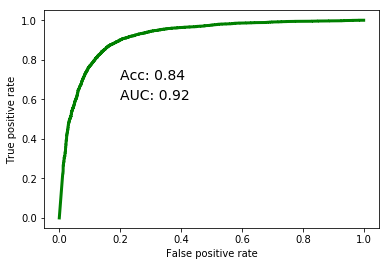

In [9]:
perf_data = performance(d_test.sentiment, pred1)

In [10]:
perf_data.head()

,fpr,tpr,thr
0,0.000000,0.000000,2.0
1,0.010163,0.207658,1.0
2,0.010163,0.208721,1.0
3,0.010163,0.213241,1.0
4,0.010163,0.214836,1.0


In [11]:
review = "I love this movie"
model1.predict(count_vectorizer.transform([review]))[0]

1

In [12]:
review = "This movie is bad"
model1.predict(count_vectorizer.transform([review]))[0]

0

In [13]:
review = "I was going to say something awesome, but I simply can't because the movie is so bad."
model1.predict(count_vectorizer.transform([review]))[0]

0

In [14]:
# TRICKED!
review = "It might have bad actors, but everything else is good."
model1.predict(count_vectorizer.transform([review]))[0]

0

In [15]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_features = tfidf_vectorizer.fit_transform(d_train.review)

In [16]:
model2 = MultinomialNB()
model2.fit(tfidf_features, d_train.sentiment)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [17]:
pred2 = model2.predict_proba(tfidf_vectorizer.transform(d_test.review))

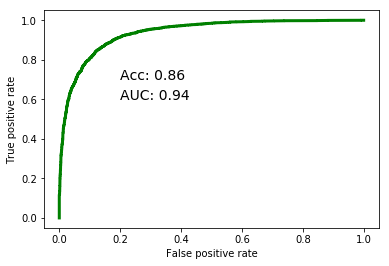

In [18]:
perf_data2 = performance(d_test.sentiment, pred2)

In [19]:
def build_model(max_features=None, min_df=1, nb_alpha=1.0):
    vectorizer = TfidfVectorizer(max_features=max_features, min_df=min_df)
    features = vectorizer.fit_transform(d_train.review)
    model = MultinomialNB(alpha=nb_alpha)
    model.fit(features, d_train.sentiment)
    pred = model.predict_proba(vectorizer.transform(d_test.review))
    
    return {
        "max_features": max_features,
        "min_df": min_df,
        "nb_alpha": nb_alpha,
        "auc": roc_auc_score(d_test.sentiment, pred[:,1])
    }

In [20]:
param_values = {
    "max_features": [10000, 30000, 50000, None],
    "min_df": [1, 2, 3],
    "nb_alpha": [0.01, 0.1, 1.0]
}

combos = list(itertools.product(*param_values.values()))

results = []
for p in combos:
    res = build_model(**dict(zip(param_values.keys(), p)))
    results.append(res)
    print(res)

{'max_features': 10000, 'min_df': 1, 'nb_alpha': 0.01, 'auc': 0.9275547899825486}
{'max_features': 10000, 'min_df': 1, 'nb_alpha': 0.1, 'auc': 0.9283647525073816}
{'max_features': 10000, 'min_df': 1, 'nb_alpha': 1.0, 'auc': 0.930977183874791}
{'max_features': 10000, 'min_df': 2, 'nb_alpha': 0.01, 'auc': 0.9276133860422904}
{'max_features': 10000, 'min_df': 2, 'nb_alpha': 0.1, 'auc': 0.9283994550281996}
{'max_features': 10000, 'min_df': 2, 'nb_alpha': 1.0, 'auc': 0.9309666593397887}
{'max_features': 10000, 'min_df': 3, 'nb_alpha': 0.01, 'auc': 0.9276432529659455}
{'max_features': 10000, 'min_df': 3, 'nb_alpha': 0.1, 'auc': 0.9284069928708365}
{'max_features': 10000, 'min_df': 3, 'nb_alpha': 1.0, 'auc': 0.9309789616678656}
{'max_features': 30000, 'min_df': 1, 'nb_alpha': 0.01, 'auc': 0.9273615794311901}
{'max_features': 30000, 'min_df': 1, 'nb_alpha': 0.1, 'auc': 0.9332378966603019}
{'max_features': 30000, 'min_df': 1, 'nb_alpha': 1.0, 'auc': 0.9359541511432738}
{'max_features': 30000, '

In [21]:
# results = [{}, {}, {}]
max_auc = max(results, key=lambda x: x['auc'])
max_auc

{'auc': 0.9365440228854592, 'max_features': None, 'min_df': 1, 'nb_alpha': 1.0}

In [22]:
results_df = pd.DataFrame(results)
results_df

,auc,max_features,min_df,nb_alpha
0,0.927555,10000.0,1,0.01
1,0.928365,10000.0,1,0.10
2,0.930977,10000.0,1,1.00
3,0.927613,10000.0,2,0.01
4,0.928399,10000.0,2,0.10
5,0.930967,10000.0,2,1.00
6,0.927643,10000.0,3,0.01
7,0.928407,10000.0,3,0.10
8,0.930979,10000.0,3,1.00
9,0.927362,30000.0,1,0.01


In [23]:
# Auc vs max_features
#data.plot(x='trip_time_in_secs', y='trip_distance', kind='scatter', s=2, xlim=(0, 5000), ylim=(0, 40))
#results_df.plot(x='max_features', y='auc', kind='line')

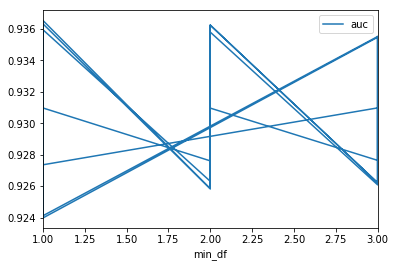

In [48]:
results_df.plot(x='min_df', y='auc', kind='line')

# Word2Vec

In [25]:
w_train = pd.read_csv(path + 'labeledTrainData.tsv', header=0, delimiter='\t', quoting=3)
w_test = pd.read_csv(path + 'testData.tsv', header=0, delimiter='\t', quoting=3)
w_train_u = pd.read_csv(path + 'unlabeledTrainData.tsv', header=0, delimiter='\t', quoting=3)

print("Read %d labeled train reviews, %d labeled test reviews, and %d unlabeled reviews" % (w_train["review"].size,  
 w_test["review"].size, w_train_u["review"].size ))

Read 25000 labeled train reviews, 25000 labeled test reviews, and 50000 unlabeled reviews


In [27]:
def review_to_wordlist( review, remove_stopwords=False ):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(review).get_text()
    #  
    # 2. Remove non-letters
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    #
    # 3. Convert words to lower case and split them
    words = review_text.lower().split()
    #
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    #
    # 5. Return a list of words
    return(words)

In [29]:
n_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [30]:
# Define a function to split a review into parsed sentences
def review_to_sentences( review, tokenizer, remove_stopwords=False ):
    # Function to split a review into parsed sentences. Returns a 
    # list of sentences, where each sentence is a list of words
    #
    # 1. Use the NLTK tokenizer to split the paragraph into sentences
    raw_sentences = tokenizer.tokenize(review.strip())
    #
    # 2. Loop over each sentence
    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append( review_to_wordlist( raw_sentence, \
              remove_stopwords ))
    #
    # Return the list of sentences (each sentence is a list of words,
    # so this returns a list of lists
    return sentences

In [32]:
sentences = []

for review in w_train['review']:
    sentences += review_to_sentences(review, n_tokenizer)
    
for review in w_train_u['review']:
    sentences += review_to_sentences(review, n_tokenizer)

/Users/troy/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/troy/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))
/Users/troy/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:219: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/Users/troy/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:282: UserWarning: "http://www.happierabroad.com"" looks like a U

In [33]:
print(len(sentences))

795538


In [34]:
print(sentences[0])

['with', 'all', 'this', 'stuff', 'going', 'down', 'at', 'the', 'moment', 'with', 'mj', 'i', 've', 'started', 'listening', 'to', 'his', 'music', 'watching', 'the', 'odd', 'documentary', 'here', 'and', 'there', 'watched', 'the', 'wiz', 'and', 'watched', 'moonwalker', 'again']


In [35]:
print(sentences[1])

['maybe', 'i', 'just', 'want', 'to', 'get', 'a', 'certain', 'insight', 'into', 'this', 'guy', 'who', 'i', 'thought', 'was', 'really', 'cool', 'in', 'the', 'eighties', 'just', 'to', 'maybe', 'make', 'up', 'my', 'mind', 'whether', 'he', 'is', 'guilty', 'or', 'innocent']


In [37]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


In [38]:
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

In [40]:
from gensim.models import word2vec

w_model = word2vec.Word2Vec(sentences, workers=num_workers, size=num_features, min_count=min_word_count, window=context, sample=downsampling)


2018-02-14 16:07:13,982 : INFO : 'pattern' package not found; tag filters are not available for English
2018-02-14 16:07:13,988 : INFO : collecting all words and their counts
2018-02-14 16:07:13,989 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-02-14 16:07:14,073 : INFO : PROGRESS: at sentence #10000, processed 225803 words, keeping 17776 word types
2018-02-14 16:07:14,154 : INFO : PROGRESS: at sentence #20000, processed 451892 words, keeping 24948 word types
2018-02-14 16:07:14,238 : INFO : PROGRESS: at sentence #30000, processed 671315 words, keeping 30034 word types
2018-02-14 16:07:14,324 : INFO : PROGRESS: at sentence #40000, processed 897815 words, keeping 34348 word types
2018-02-14 16:07:14,404 : INFO : PROGRESS: at sentence #50000, processed 1116963 words, keeping 37761 word types
2018-02-14 16:07:14,487 : INFO : PROGRESS: at sentence #60000, processed 1338404 words, keeping 40723 word types
2018-02-14 16:07:14,567 : INFO : PROGRESS: at senten

2018-02-14 16:07:19,156 : INFO : PROGRESS: at sentence #710000, processed 15880202 words, keeping 117596 word types
2018-02-14 16:07:19,237 : INFO : PROGRESS: at sentence #720000, processed 16105489 words, keeping 118221 word types
2018-02-14 16:07:19,320 : INFO : PROGRESS: at sentence #730000, processed 16331870 words, keeping 118954 word types
2018-02-14 16:07:19,399 : INFO : PROGRESS: at sentence #740000, processed 16552903 words, keeping 119668 word types
2018-02-14 16:07:19,479 : INFO : PROGRESS: at sentence #750000, processed 16771230 words, keeping 120295 word types
2018-02-14 16:07:19,557 : INFO : PROGRESS: at sentence #760000, processed 16990622 words, keeping 120930 word types
2018-02-14 16:07:19,645 : INFO : PROGRESS: at sentence #770000, processed 17217759 words, keeping 121703 word types
2018-02-14 16:07:19,732 : INFO : PROGRESS: at sentence #780000, processed 17447905 words, keeping 122402 word types
2018-02-14 16:07:19,814 : INFO : PROGRESS: at sentence #790000, processe

In [41]:
# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
w_model.init_sims(replace=True)

2018-02-14 16:20:29,094 : INFO : precomputing L2-norms of word weight vectors


In [42]:
w_model.save(path + '300features_40minwords_10context.model')

2018-02-14 16:22:39,083 : INFO : saving Word2Vec object under /Users/troy/code/machine-learning/imdb-example/data/300features_40minwords_10context.model, separately None
2018-02-14 16:22:39,086 : INFO : not storing attribute syn0norm
2018-02-14 16:22:39,089 : INFO : not storing attribute cum_table
2018-02-14 16:22:39,623 : INFO : saved /Users/troy/code/machine-learning/imdb-example/data/300features_40minwords_10context.model


In [44]:
w_model.doesnt_match('man woman child kitchen'.split())

'kitchen'

In [45]:
w_model.doesnt_match('france england germany berlin'.split())

'berlin'

In [46]:
w_model.doesnt_match('paris berlin london austria'.split())

'paris'

In [47]:
w_model.most_similar('man')

[('woman', 0.621594250202179),
 ('lad', 0.612229585647583),
 ('lady', 0.5972335934638977),
 ('monk', 0.530863344669342),
 ('men', 0.5270383954048157),
 ('businessman', 0.525122344493866),
 ('guy', 0.5202241539955139),
 ('millionaire', 0.5199412703514099),
 ('chap', 0.5133419036865234),
 ('sailor', 0.5126751661300659)]

In [51]:
w_model.most_similar('queen')

[('princess', 0.6648591160774231),
 ('belle', 0.6162021160125732),
 ('goddess', 0.5977149605751038),
 ('duchess', 0.5931840538978577),
 ('stepmother', 0.5750319361686707),
 ('maid', 0.5708911418914795),
 ('victoria', 0.5687952637672424),
 ('mistress', 0.5654619932174683),
 ('katherine', 0.5603786110877991),
 ('showgirl', 0.5597378611564636)]

In [52]:
w_model.most_similar('awful')

[('terrible', 0.7568886280059814),
 ('atrocious', 0.7316727042198181),
 ('dreadful', 0.7256795763969421),
 ('horrible', 0.7219803929328918),
 ('abysmal', 0.697673499584198),
 ('horrid', 0.6943425536155701),
 ('horrendous', 0.688029944896698),
 ('appalling', 0.6591892838478088),
 ('lousy', 0.6265116930007935),
 ('amateurish', 0.6120062470436096)]

In [61]:
#w_model.wv.save_word2vec_format(path + '300features_40minwords_10context.w2v_format')
word_vectors = w_model.wv
word_vectors.save(path + 'word-vectors')

2018-02-15 12:20:18,900 : INFO : saving KeyedVectors object under /Users/troy/code/machine-learning/imdb-example/data/word-vectors, separately None
2018-02-15 12:20:18,905 : INFO : not storing attribute syn0norm
2018-02-15 12:20:19,357 : INFO : saved /Users/troy/code/machine-learning/imdb-example/data/word-vectors
